In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model, PytorchModel, MultiModel, AutoEncoderModel
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# make experiments reproducable
import torch as t
t.manual_seed(0)

# globals
SYMBOL = "T"
START_DATE = "1995-01-01"
MODEL_REPOSITORY = "/home/kic/models"

automatically imported pandas_ml_utils 0.1.5


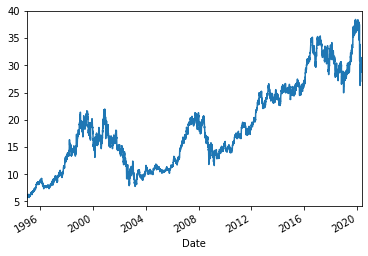

In [2]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)
df["Close"].plot()

In [3]:
import torch as t
import torch.nn as nn
from pandas_ml_utils.pytorch import Reshape

encoder_model = Model.load(f"{MODEL_REPOSITORY}/{SYMBOL}-ConvAE.model")
encoded_df = df.model.predict(encoder_model.as_encoder())
encoded_df.tail()

prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-05-04   0.324016   0.089808  -0.183419   0.258450   
2020-05-05   0.461329   0.163286  -0.030649   0.347903   
2020-05-06   0.536949   0.282535  -0.002106  -0.266770   
2020-05-07   0.526014   0.208441   0.180655  -0.417756   
2020-05-08   0.202562   0.196009  -0.001531  -0.421202   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-05-04  [[-0.9912015826738856, -0.958938135695799, -0....  
2020-05-05  [[-0.9620470637234488, -0.9791484670551369, -0...  
2020-05-06  [[-1.0, -0.9330107544676267, -0.95176814577174...  
2020-05-07  [[-0.9971303948576675, -0.9992823411973384, -0...  
2020-05-08  [[-0.7130394857667586, -0.9104713113234343, -0...

In [4]:
from functools import partial
from torch.optim import Adam, AdamW
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_quant.model.summary import BinaryWeightedClassificationSummary, MultipleBinaryWeightedClassificationSummary


# fixme, should be part of features and labels
forcasting_range=range(1, 11)
    
def module_provider():
    
    class FNN(nn.Module):
        
        def __init__(self):
            super().__init__()
            nr_features = 14
            self.model = nn.Sequential(
                Reshape(200 * nr_features),
                nn.Linear(200 * nr_features, 30),
                nn.Dropout(0.33),
                nn.Tanh(),
                nn.Linear(30, 20),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(20, 20),
                nn.Dropout(0.1),
                nn.LeakyReLU(),
                nn.Linear(20, 1),
                nn.Dropout(0.0001),
                nn.Sigmoid()
            )
            
        def forward(self, x):
            return self.model(x)
        
    return FNN()

tfitmm = df.model.fit(
    MultiModel(
        PytorchModel(
            PostProcessedFeaturesAndLabels(
                features=[
                    lambda df, ae_model: df.ta.model(ae_model),
                    lambda df: df["Close"].ta.macd(),
                    lambda df: df.ta.atr(),
                    lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']],
                    lambda df: (df["Volume"] / df["Volume"].ta.sma(20)).rename("Volume"),
                    lambda df: df["Close"].ta.stddev(20)
                ],
                feature_post_processor=[
                    lambda df: df.ta.rnn(200)
                ],
                labels=[
                    partial(lambda i, df: (df["Close"].shift(-i) > df["Close"].ta.sma(20)).rename(f"label_{i}"), i) for i in forcasting_range
                ],
                targets=[
                    lambda df: df["Close"].ta.sma(20),
                ],
                gross_loss=[
                    partial(lambda i, df: (df["Close"].shift(-i) - df["Close"].ta.sma(20)).rename(f"gl_{i}"), i) for i in forcasting_range
                ],
                sample_weights=[
                    partial(lambda i, df: (((np.log(df["Close"]).shift(-i) - np.log(df["Close"].ta.sma(20)) + 1).abs() * 2) ** 8).rename(f"sample_weight_{i}"), i) for i in forcasting_range
                ],
                ae_model=encoder_model,
            ),
            module_provider,
            lambda: nn.BCELoss(reduction='none'),
            lambda p: Adam(p, weight_decay=0.0001),
        ),
        len(forcasting_range),
        summary_provider=MultipleBinaryWeightedClassificationSummary,
    ),
    RandomSplits(
        test_size=0.2,
        youngest_size=0.05,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=5).split)
    ),
    batch_size=32,
    epochs=30,
    verbose=0,
    figsize=(30, 5),
    # on_epoch=[PytorchModel.Callbacks.print_loss(2)],
    #on_epoch=[PytorchModel.Callbacks.early_stopping(patience=3), lambda epoch, loss, val_loss: print(f"{epoch}: {loss}\t {val_loss}") if epoch % 2 == 0 else None]
)

tfitmm

In [5]:
tfitmm.model.save(f"/home/kic/models/{SYMBOL}-ConveAE-PyTorchFNN-t+1_to_10.model")

saved model to: /home/kic/models/T-ConveAE-PyTorchFNN-t+1_to_10.model


In [6]:
df.model.predict(tfitmm.model, tail=10)

target prediction                                          \
           Close_sma_20    label_1   label_2   label_3   label_4   label_5   
Date                                                                         
2020-04-27      29.6580   0.999923  0.990488  0.997661  0.999838  0.998580   
2020-04-28      29.7050   0.999546  0.997569  0.999881  0.999841  0.999444   
2020-04-29      29.8440   0.999974  0.999398  0.999910  0.999843  0.999390   
2020-04-30      29.9890   0.999926  0.999766  0.999913  0.999835  0.999260   
2020-05-01      30.0710   0.999906  0.999778  0.999796  0.999755  0.997790   
2020-05-04      30.2015   0.999662  0.955228  0.583470  0.854603  0.110078   
2020-05-05      30.2420   0.015567  0.017572  0.263062  0.885671  0.025928   
2020-05-06      30.2035   0.000197  0.001108  0.000825  0.252639  0.017391   
2020-05-07      30.1535   0.000287  0.077707  0.012818  0.564921  0.069174   
2020-05-08      30.1065   0.004167  0.077755  0.010162  0.599603  0.632201   

                                                    ...  \
             label_6   label_7   label_8   label_9  ...   
Date                                                ...   
2020-04-27  0.999781  0.988442  0.998661  0.995969  ...   
2020-04-28  0.999774  0.989960  0.998408  0.999539  ...   
2020-04-29  0.999711  0.987822  0.998247  0.999701  ...   
2020-04-30  0.999452  0.990342  0.992653  0.999070  ...   
2020-05-01  0.998288  0.933422  0.081425  0.997968  ...   
2020-05-04  0.502421  0.632435  0.063139  0.986311  ...   
2020-05-05  0.461538  0.510099  0.113447  0.971047  ...   
2020-05-06  0.454782  0.553454  0.039043  0.621880  ...   
2020-05-07  0.946259  0.322253  0.198646  0.958739  ...   
2020-05-08  0.975732  0.363793  0.359910  0.937579  ...   

                          feature                         \
           (190, Close_stddev_20) (191, Close_stddev_20)   
Date                                                       
2020-04-27               0.005067               0.005507   
2020-04-28               0.005126               0.005067   
2020-04-29               0.005509               0.005126   
2020-04-30               0.005648               0.005509   
2020-05-01               0.005780               0.005648   
2020-05-04               0.005936               0.005780   
2020-05-05               0.006070               0.005936   
2020-05-06               0.006055               0.006070   
2020-05-07               0.006123               0.006055   
2020-05-08               0.006206               0.006123   

                                                          \
           (192, Close_stddev_20) (193, Close_stddev_20)   
Date                                                       
2020-04-27               0.005975               0.005975   
2020-04-28               0.005507               0.005975   
2020-04-29               0.005067               0.005507   
2020-04-30               0.005126               0.005067   
2020-05-01               0.005509               0.005126   
2020-05-04               0.005648               0.005509   
2020-05-05               0.005780               0.005648   
2020-05-06               0.005936               0.005780   
2020-05-07               0.006070               0.005936   
2020-05-08               0.006055               0.006070   

                                                          \
           (194, Close_stddev_20) (195, Close_stddev_20)   
Date                                                       
2020-04-27               0.006105               0.006470   
2020-04-28               0.005975               0.006105   
2020-04-29               0.005975               0.005975   
2020-04-30               0.005507               0.005975   
2020-05-01               0.005067               0.005507   
2020-05-04               0.005126               0.005067   
2020-05-05               0.005509               0.005126   
2020-05-06               0.005648               0.005509   
2020-05-07  

In [7]:
iyz = pd.fetch_yahoo("iyz")
bt = iyz.model.backtest(tfitmm.model, MultipleBinaryWeightedClassificationSummary)
bt

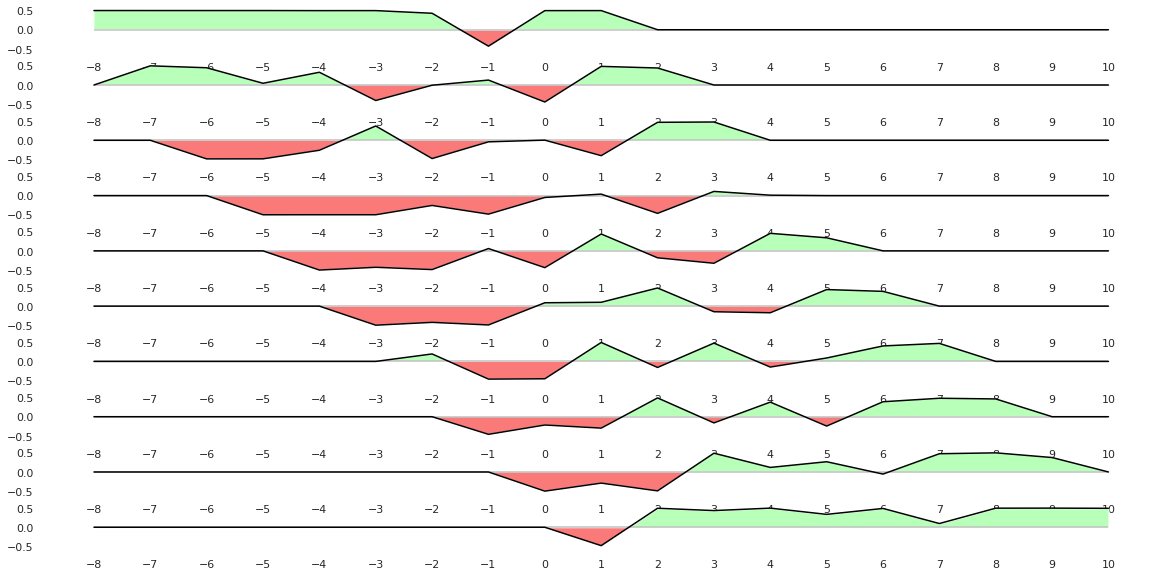

In [111]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)

dfp = df.model.predict(tfitmm.model, tail=10)

prediction = dfp["prediction"]
padding = pd.DataFrame(np.ones((prediction.shape[0], prediction.shape[0] - 1)) * 0.5, index=prediction.index)
data = prediction.join(padding).T

fig, ax = plt.subplots(len(data.columns), 1, figsize=(20,10))
x = np.arange(-len(prediction) + 2, len(prediction) + 1)

for i, col in enumerate(data.columns):
    y = data[col].shift(i, fill_value=0.5).values - 0.5
    ax[i].plot(x, y, color='black')
    ax[i].fill_between(x, y, where=y > 0, facecolor='#b8ffba', interpolate=True)
    ax[i].fill_between(x, y, where=y < 0, facecolor='#fa7a7a', interpolate=True)
    ax[i].hlines(0, x.min(), x.max(), color='silver')
    ax[i].set_ylim(-0.6, 0.6)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xticks(x)


df["Close"].ta.sma(20)[-1:]

In [112]:
pconv_model = Model.load(f"/home/kic/models/{SYMBOL}-Predictive-BN-Var-ConvAE.model")

In [126]:
df_gaf = df.model.predict(pconv_model.as_trainable(), tail=10)["prediction"].ta.inverse_gasf()
df_gaf

  warnings.warn(msg, UserWarning)



,"(Close_gaf, 0)","(Close_gaf, 1)","(Close_gaf, 2)","(Close_gaf, 3)","(Close_gaf, 4)","(Close_gaf, 5)","(Close_gaf, 6)","(Close_gaf, 7)","(Close_gaf, 8)","(Close_gaf, 9)","(Close_gaf, 10)","(Close_gaf, 11)","(Close_gaf, 12)","(Close_gaf, 13)","(Close_gaf, 14)","(Close_gaf, 15)"
Date,,,,,,,,,,,,,,,,
2020-05-01,0.534247,0.544201,0.587595,0.616237,0.631976,0.665999,0.638490,0.553748,0.564501,0.556032,0.567102,0.611194,0.585815,0.568139,0.564432,0.573359
2020-05-04,0.467344,0.538337,0.607473,0.663005,0.687441,0.723575,0.676142,0.519047,0.538077,0.544931,0.567553,0.637324,0.594620,0.562400,0.548775,0.556276
2020-05-05,0.441521,0.401193,0.485299,0.546908,0.600659,0.712205,0.718859,0.652937,0.642654,0.633645,0.652472,0.699650,0.669040,0.638260,0.617629,0.569975
2020-05-06,0.462840,0.506679,0.586097,0.650300,0.681997,0.737957,0.689826,0.529096,0.544237,0.553844,0.584917,0.666842,0.622554,0.583060,0.562233,0.554535
2020-05-07,0.638580,0.581763,0.583053,0.568477,0.571320,0.586013,0.578497,0.564489,0.565807,0.555386,0.555026,0.564872,0.559441,0.559701,0.570619,0.591147
2020-05-08,0.796887,0.462650,0.397795,0.310925,0.330269,0.344205,0.449790,0.683586,0.648590,0.645067,0.676815,0.674609,0.717681,0.713648,0.705956,0.672882
2020-05-11,0.860285,0.663991,0.521478,0.377864,0.345992,0.317633,0.405902,0.729948,0.699203,0.604844,0.535217,0.396989,0.465120,0.555656,0.619906,0.679611
2020-05-12,0.821524,0.813591,0.734010,0.656216,0.600305,0.488793,0.431499,0.391392,0.410722,0.447564,0.446615,0.436123,0.445701,0.464179,0.494849,0.605747
2020-05-13,0.652075,0.768003,0.753791,0.747043,0.715606,0.650890,0.554827,0.417136,0.433406,0.453179,0.435463,0.425542,0.404094,0.424149,0.459999,0.562867


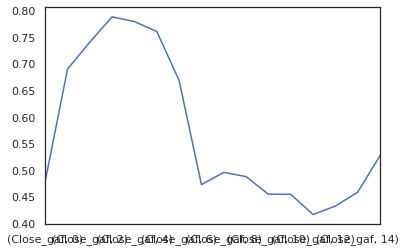

In [163]:
df_gaf.iloc[-1].plot()

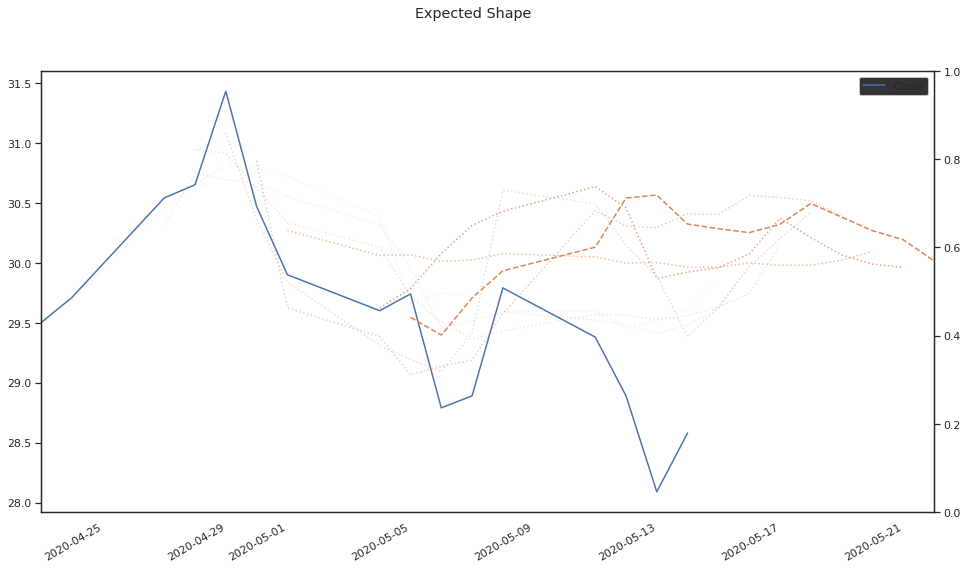

In [216]:
def nans(shape):
    arr = np.empty(shape)
    arr.fill(np.nan)
    return arr
    
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
fig.suptitle("Expected Shape")
ax2 = ax.twinx()

pd.concat([df._[["Close"]], pd.DataFrame({}, index=pd.date_range(df.index[-1], periods=9, freq='D')[1:])], axis=0, sort=True)[-24:].plot(ax=ax)

alphas = np.logspace(0.1, 1.0, 8) / 10
for i in range(1, 9):
    style = 'C1:' if i < 8 else 'C1--'
    ax2.plot(ax.lines[0].get_xdata(), np.hstack([nans(i), df_gaf.iloc[-(i)].values, nans(8 - i)]), style, alpha=alphas[i-1])
    ax2.set_ylim((0, 1))


In [212]:
np.logspace(0.1, 1.0, 8) / 10
max(range(9))

8

In [ ]:
padding = pd.DataFrame(np.ones((prediction.shape[0], prediction.shape[0] - 1)) * 0.5, index=prediction.index)
data = prediction.join(padding).T

fig, ax = plt.subplots(len(data.columns), 1, figsize=(20,10))
x = np.arange(-len(prediction) + 2, len(prediction) + 1)

for i, col in enumerate(data.columns):
    y = data[col].shift(i, fill_value=0.5).values - 0.5
    ax[i].plot(x, y, color='black')
    ax[i].fill_between(x, y, where=y > 0, facecolor='#b8ffba', interpolate=True)
    ax[i].fill_between(x, y, where=y < 0, facecolor='#fa7a7a', interpolate=True)
    ax[i].hlines(0, x.min(), x.max(), color='silver')
    ax[i].set_ylim(-0.6, 0.6)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xticks(x)

    
